# Imports

In [1]:
import tsplib95
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
random.seed(42)
from typing import Literal

# Data loading

In [2]:
class Instance:
    def __init__(self, problem_name):
        self.problem = tsplib95.load(f"{problem_name}.tsp")
        self.nodes = list(self.problem.get_nodes())
        self.distance_matrix = self._compute_distance_matrix()
        self.coords = np.array([self.problem.node_coords[i] for i in self.nodes])

    def _compute_distance_matrix(self):
        n = len(self.nodes)
        matrix = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                if i != j:
                    matrix[i][j] = self.problem.get_weight(self.nodes[i], self.nodes[j])
        return matrix

In [3]:
instanceA = Instance("kroA200")
instanceB = Instance("kroB200")

# Solution

In [4]:
OUTSIDE_MOVE = False
INSIDE_MOVE = True
CYCLE_1 = 1
CYCLE_2 = 2

class Solution(Instance):
    def __init__(self, problem_name: str, starting_solution: Literal["rand", "weighted2regret"] = "rand", 
                 inside_swap_type: Literal["edge", "vertex"] = "edge"):
        """
        Initialize the solution instance.
        :param problem_name: Name of the problem instance (e.g., "kroA200", "kroB200").
        :param starting_solution: The type of initial solution to generate.
                                  "rand" for random, "weighted2regret" for weighted 2-regret.
        """
        super().__init__(problem_name)
        self.cycle1 = None
        self.cycle2 = None
        self.total_length = None
        self.inside_swap_type = inside_swap_type
        if starting_solution == "rand":
            self.__random_solution()
        elif starting_solution == "weighted2regret":
            self.__weighted_2regret()
        else:
            raise ValueError("Invalid starting solution type. Use 'rand' or 'weighted2regret'.")

    def cycle_length(self):
        len1 = sum(
            self.distance_matrix[self.cycle1[i], self.cycle1[(i + 1) % len(self.cycle1)]]
            for i in range(len(self.cycle1))
        )
        len2 = sum(
            self.distance_matrix[self.cycle2[i], self.cycle2[(i + 1) % len(self.cycle2)]]
            for i in range(len(self.cycle2))
        )
        return len1 + len2
    
    def plot_cycles(self, title=""):
        plt.figure(figsize=(8, 6))
        coords = self.coords
        
        # Draw cycle 1
        for i in range(len(self.cycle1)):
            a = coords[self.cycle1[i]]
            b = coords[self.cycle1[(i + 1) % len(self.cycle1)]]
            plt.plot([a[0], b[0]], [a[1], b[1]], 'b-', linewidth=1.5)
        plt.scatter(coords[self.cycle1, 0], coords[self.cycle1, 1], c='blue', label='Cycle 1')

        # Draw cycle 2
        for i in range(len(self.cycle2)):
            a = coords[self.cycle2[i]]
            b = coords[self.cycle2[(i + 1) % len(self.cycle2)]]
            plt.plot([a[0], b[0]], [a[1], b[1]], 'orange', linewidth=1.5)
        plt.scatter(coords[self.cycle2, 0], coords[self.cycle2, 1], c='orange', label='Cycle 2')

        # Draw labels
        for i, (x, y) in enumerate(coords):
            plt.text(x, y, str(i), fontsize=6, ha='center', va='center')

        plt.title(title)
        plt.axis('equal')
        plt.legend()
        plt.grid(True)
        plt.show()

    def __random_solution(self):
        n = len(self.nodes)
        indices = list(range(n))
        random.shuffle(indices)

        # Split into two cycles
        mid = n // 2
        self.cycle1 = indices[:mid]
        self.cycle2 = indices[mid:]

        # Calculate total length of the cycles
        self.total_length = self.cycle_length()
        return
    
    def __insert_best_weighted(self, cycle, unvisited, w=-0.5):
        def strategy(a, n, b):
            return self.distance_matrix[a][n] + self.distance_matrix[n][b] - self.distance_matrix[a][b]
        best_score = float('inf')
        best_node = None
        best_pos = None

        for node in unvisited:
            insertions = []
            for i in range(len(cycle)):
                a, b = cycle[i], cycle[(i + 1) % len(cycle)]
                score = strategy(a, node, b)
                insertions.append((score, i + 1))
            insertions.sort()

            if len(insertions) >= 2:
                regret = insertions[1][0] - insertions[0][0]
            else:
                regret = 0
            
            total_score = ((1 + w) * insertions[0][0]) + (w * regret)

            if total_score < best_score:
                best_score = total_score
                best_node = node
                best_pos = insertions[0][1]

        return best_node, best_pos

    def __weighted_2regret(self):
        n = len(self.nodes)
        t1, t2 = n // 2 + n % 2, n // 2
        s1 = random.randint(0, n - 1)
        s2 = max(range(n), key=lambda i: self.distance_matrix[s1][i])

        self.cycle1 = [s1, min(range(n), key=lambda i: self.distance_matrix[s1][i] if i != s1 else float('inf'))]
        self.cycle2 = [s2, min(range(n), key=lambda i: self.distance_matrix[s2][i] if i != s2 else float('inf'))]

        unvisited = set(range(n)) - {s1, s2, self.cycle1[1], self.cycle2[1]}

        while len(self.cycle1) < t1 or len(self.cycle2) < t2:
            if len(self.cycle1) < t1:
                node, pos = self.__insert_best_weighted(self.cycle1, unvisited)
                self.cycle1.insert(pos, node)
                unvisited.remove(node)
            if len(self.cycle2) < t2 and unvisited:
                node, pos = self.__insert_best_weighted(self.cycle2, unvisited)
                self.cycle2.insert(pos, node)
                unvisited.remove(node)
        self.total_length = self.cycle_length()
        return
    
    def old_generate_neighborhood(self):
        neighborhood = []
        cycle_length = len(self.cycle1)

        cycle1_node_ids = list(range(len(self.cycle1)))
        cycle2_node_ids = list(range(len(self.cycle2)))

        for i in cycle1_node_ids:
            for j in cycle2_node_ids[i:]:
                neighborhood.append((i, j, OUTSIDE_MOVE))

        if self.inside_swap_type == "vertex":
            for i in cycle1_node_ids:
                for j in cycle1_node_ids[i+1:]:
                    neighborhood.append((i, j, INSIDE_MOVE))

        elif self.inside_swap_type == "edge":
            for i in range(cycle_length):
                for j in range(cycle_length):
                    if i == j:
                        continue
                    if (j == (i + 1) % cycle_length) or (j == (i - 1) % cycle_length):
                        continue
                    neighborhood.append((i, j, INSIDE_MOVE))

        return neighborhood

    def generate_neighborhood(self):
        neighborhood = []
        cycle_length = len(self.cycle1)

        cycle1_node_ids = list(range(len(self.cycle1)))
        cycle2_node_ids = list(range(len(self.cycle2)))

        for i in cycle1_node_ids:
            for j in cycle2_node_ids[i:]:
                neighborhood.append((i, j, OUTSIDE_MOVE))

        if self.inside_swap_type == "vertex":
            for i in cycle1_node_ids:
                for j in cycle1_node_ids[i+1:]:
                    neighborhood.append((i, j, INSIDE_MOVE))

        elif self.inside_swap_type == "edge":
            for i in range(1, cycle_length - 2):
                for j in range(i + 1, cycle_length - 1):
                    neighborhood.append((i, j, INSIDE_MOVE))

        return neighborhood

    def outside_move_delta(self, move):
        cycle_length = len(self.cycle1)
        cycle1_id, cycle2_id = move[0], move[1]

        c1_node = self.cycle1[cycle1_id]
        c2_node = self.cycle2[cycle2_id]

        c1_node_before = self.cycle1[cycle1_id - 1]
        c2_node_before = self.cycle2[cycle2_id - 1]

        c1_node_after = self.cycle1[(cycle1_id + 1) % cycle_length]
        c2_node_after = self.cycle2[(cycle2_id + 1) % cycle_length]

        temp_score = self.total_length

        temp_score = temp_score - self.distance_matrix[c1_node_before][c1_node] - self.distance_matrix[c1_node][c1_node_after] \
            - self.distance_matrix[c2_node_before][c2_node] - self.distance_matrix[c2_node][c2_node_after] \
            + self.distance_matrix[c1_node_before][c2_node] + self.distance_matrix[c1_node_after][c2_node] \
            + self.distance_matrix[c2_node_before][c1_node] + self.distance_matrix[c2_node_after][c1_node]
        
        return temp_score

    def outside_move(self, move):
        cycle1_id, cycle2_id = move[0], move[1]

        self.cycle1[cycle1_id], self.cycle2[cycle2_id] = self.cycle2[cycle2_id], self.cycle1[cycle1_id]
        
    
    def __inside_edge_delta(self, move, c=CYCLE_1):
        cycle_length = len(self.cycle1)
        id1, id2 = move[0], move[1]
        cycle = self.cycle1 if c == CYCLE_1 else self.cycle2

        beginning_node1 = cycle[id1]
        beginning_node2 = cycle[id2]

        end_node1 = cycle[(id1 + 1) % cycle_length]
        end_node2 = cycle[(id2 + 1) % cycle_length]

        temp_score = self.total_length

        temp_score = temp_score - self.distance_matrix[beginning_node1][end_node1] - self.distance_matrix[beginning_node2][end_node2] \
            + self.distance_matrix[beginning_node1][beginning_node2] + self.distance_matrix[end_node1][end_node2]

        return temp_score
    

    def __inside_vertex_delta(self, move, c=CYCLE_1):
        cycle_length = len(self.cycle1)
        id1, id2 = move[0], move[1]
        cycle = self.cycle1 if c == CYCLE_1 else self.cycle2

        node1 = cycle[id1]
        node2 = cycle[id2]

        before_node1 = cycle[id1 - 1]
        before_node2 = cycle[id2 - 1]

        after_node1 = cycle[(id1 + 1) % cycle_length]
        after_node2 = cycle[(id2 + 1) % cycle_length]

        temp_score = self.total_length

        if (id1 == 0 and id2 == cycle_length - 1):
            temp_score = temp_score - self.distance_matrix[before_node2][node2] - self.distance_matrix[after_node1][node1] \
                + self.distance_matrix[before_node2][node1] + self.distance_matrix[node2][after_node1]

        elif abs(id2 - id1) == 1:
            temp_score = temp_score - self.distance_matrix[before_node1][node1] - self.distance_matrix[node2][after_node2] \
                + self.distance_matrix[before_node1][node2] + self.distance_matrix[node1][after_node2]

        else:
            temp_score = temp_score - self.distance_matrix[before_node1][node1] - self.distance_matrix[node1][after_node1] \
                - self.distance_matrix[before_node2][node2] - self.distance_matrix[node2][after_node2] \
                + self.distance_matrix[before_node1][node2] + self.distance_matrix[node2][after_node1] \
                + self.distance_matrix[before_node2][node1] + self.distance_matrix[node1][after_node2]

        return temp_score
    
    def __inside_edge_swap(self, move, c=CYCLE_1):
        id1, id2 = move[0], move[1]
        cycle_length = len(self.cycle1)
        
        if c == CYCLE_1:
            if id1 < id2:
                self.cycle1[id1+1:id2+1] = self.cycle1[id1+1:id2+1][::-1]
            else:
                segment = self.cycle1[id1+1:] + self.cycle1[:id2+1]
                segment = segment[::-1]

                self.cycle1[id1+1:] = segment[:cycle_length - id1 - 1]
                self.cycle1[:id2+1] = segment[cycle_length - id1 - 1:]
            
        else:
            if id1 < id2:
                self.cycle2[id1+1:id2+1] = self.cycle2[id1+1:id2+1][::-1]
            else:
                segment = self.cycle2[id1+1:] + self.cycle2[:id2+1]
                segment = segment[::-1]
                
                self.cycle2[id1+1:] = segment[:cycle_length - id1 - 1]
                self.cycle2[:id2+1] = segment[cycle_length - id1 - 1:]

    
    def __inside_vertex_swap(self, move, c=CYCLE_1):
        id1, id2 = move[0], move[1]
        
        if c == CYCLE_1:
            self.cycle1[id1], self.cycle1[id2] = self.cycle1[id2], self.cycle1[id1]
            
        else:
            self.cycle2[id1], self.cycle2[id2] = self.cycle2[id2], self.cycle2[id1]


    def inside_move_delta(self, move, c):
        if self.inside_swap_type == "edge":
            return self.__inside_edge_delta(move, c)
        elif self.inside_swap_type == "vertex":
            return self.__inside_vertex_delta(move, c)
        else:
            raise ValueError("Invalid inside swap type. Use 'edge' or 'vertex'.")
        
    def inside_move(self, move, c):
        if self.inside_swap_type == "edge":
            return self.__inside_edge_swap(move, c)
        elif self.inside_swap_type == "vertex":
            return self.__inside_vertex_swap(move, c)
        else:
            raise ValueError("Invalid inside swap type. Use 'edge' or 'vertex'.")

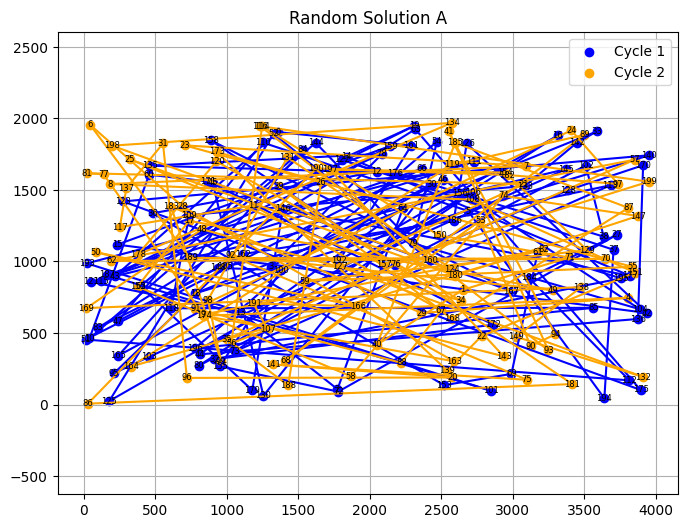

np.float64(345279.0)

In [5]:
solutionA = Solution("kroA200")
solutionA.plot_cycles("Random Solution A")
solutionA.total_length

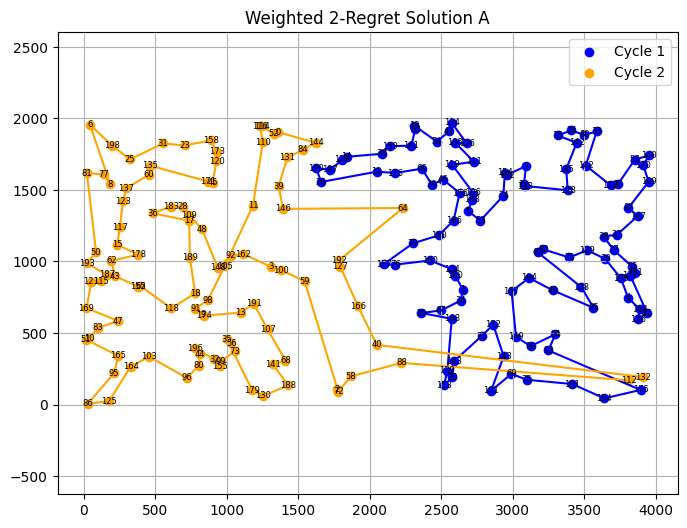

np.float64(37447.0)

In [6]:
solutionA = Solution("kroA200", "weighted2regret")
solutionA.plot_cycles("Weighted 2-Regret Solution A")
solutionA.total_length

In [7]:
class RandomWalk(Solution):
    def __init__(self, problem_name: str, starting_solution: Literal["rand", "weighted2regret"] = "rand", 
                 inside_swap_type: Literal["edge", "vertex"] = "edge", time_limit=1):
        super().__init__(problem_name, starting_solution, inside_swap_type)
        self.time_limit = time_limit
        self.random_walk()


    def random_walk(self):
        start_time = time.time()
        neighborhood = self.old_generate_neighborhood()
        neighborhood_ids = np.arange(len(neighborhood))
        best_score = float('inf')
        best_cycle1 = self.cycle1.copy()
        best_cycle2 = self.cycle2.copy()
        self.moves_made = 0

        while time.time() - start_time < self.time_limit:
            random_id = np.random.choice(neighborhood_ids)
            move = neighborhood[random_id]

            if move[2] == OUTSIDE_MOVE:
                new_score = self.outside_move_delta(move)
                self.outside_move(move)
                
                if new_score < best_score:
                    best_score = new_score
                    best_cycle1 = self.cycle1.copy()
                    best_cycle2 = self.cycle2.copy()

                self.total_length = new_score

            elif move[2] == INSIDE_MOVE:
                c = CYCLE_1 if random.random() < 0.5 else CYCLE_2
                new_score = self.inside_move_delta(move, c)
                self.inside_move(move, c)
                
                if new_score < best_score:
                    best_score = new_score
                    best_cycle1 = self.cycle1.copy()
                    best_cycle2 = self.cycle2.copy()

                self.total_length = new_score

            self.moves_made += 1

        
        self.cycle1 = best_cycle1
        self.cycle2 = best_cycle2
        self.total_length = best_score


In [8]:
class GreedySolution(Solution):
    def __init__(self, problem_name: str, starting_solution: Literal["rand", "weighted2regret"] = "rand", 
                 inside_swap_type: Literal["edge", "vertex"] = "edge"):
        super().__init__(problem_name, starting_solution, inside_swap_type)
        self.greedy_solution()


    def greedy_solution(self):
        neighborhood = self.old_generate_neighborhood()
        neighborhood_ids = np.arange(len(neighborhood))

        impovement_found = True
        while impovement_found:
            impovement_found = False

            np.random.shuffle(neighborhood_ids)
            for id in neighborhood_ids:
                move = neighborhood[id]
                if move[2] == OUTSIDE_MOVE:
                    new_score = self.outside_move_delta(move)

                    if new_score < self.total_length:
                        self.outside_move(move)
                        # print(self.total_length, new_score, self.cycle_length(), move)

                        self.total_length = new_score
                        impovement_found = True
                        break

                elif move[2] == INSIDE_MOVE:
                    if random.random() < 0.5:
                        c = CYCLE_1
                    else:
                        c = CYCLE_2

                    new_score = self.inside_move_delta(move, c)

                    if new_score < self.total_length:
                        self.inside_move(move, c)

                        # print(self.total_length, new_score, self.cycle_length(), move)
                        self.total_length = new_score
                        impovement_found = True
                        break

                    if c == CYCLE_1:
                        c = CYCLE_2
                    else:
                        c = CYCLE_1
                    new_score = self.inside_move_delta(move, c)

                    if new_score < self.total_length:
                        self.inside_move(move, c)
                        # print(self.total_length, new_score, self.cycle_length(), move)

                        self.total_length = new_score
                        impovement_found = True
                        break


In [ ]:
class SteepestSolution(Solution):
    def __init__(self, problem_name: str, starting_solution: Literal["rand", "weighted2regret"] = "rand", 
                 inside_swap_type: Literal["edge", "vertex"] = "edge"):
        super().__init__(problem_name, starting_solution, inside_swap_type)
        self.steepest_solution()

    def steepest_solution(self):
        neighborhood = self.old_generate_neighborhood()

        impovement_found = True
        while impovement_found:
            impovement_found = False
            
            best_score = float('inf')
            best_move = None
            cycle_change = None

            for move in neighborhood:
                if move[2] == OUTSIDE_MOVE:
                    new_score = self.outside_move_delta(move)

                    if new_score < best_score:
                        best_score = new_score
                        best_move = move

                        
                elif move[2] == INSIDE_MOVE:
                    new_score = self.inside_move_delta(move, CYCLE_1)

                    if new_score < best_score:
                        best_score = new_score
                        best_move = move
                        cycle_change = CYCLE_1

                    new_score = self.inside_move_delta(move, CYCLE_2)

                    if new_score < best_score:
                        best_score = new_score
                        best_move = move
                        cycle_change = CYCLE_2


            if best_move is not None and best_score < self.total_length:
                if best_move[2] == OUTSIDE_MOVE:
                    self.outside_move(best_move)
                    self.total_length = best_score
                    impovement_found = True

                elif best_move[2] == INSIDE_MOVE:
                    self.inside_move(best_move, cycle_change)
                    self.total_length = best_score
                    impovement_found = True
        

In [10]:
instances = ["kroA200", "kroB200"]
starting_solutions = ["rand", "weighted2regret"]
neighborhood_types = ["edge", "vertex"]

with open("results.csv", "w") as f:
    f.write(f"instance;starting_solution;neighborhood_type;algorithm;runtime;score;cycle1;cycle2\n")

num_tests = 100
for instance in instances:
    for starting_solution in starting_solutions:
        for neighborhood_type in neighborhood_types:
            for i in range(num_tests):
                start_time = time.time()
                greedy_solution = GreedySolution(instance, starting_solution, neighborhood_type)
                end_time = time.time()
                greedy_elapsed_time = end_time - start_time

                start_time = time.time()
                steepest_solution = SteepestSolution(instance, starting_solution, neighborhood_type)
                end_time = time.time()
                steepest_elapsed_time = end_time - start_time

                with open("results.csv", "a") as f:
                    f.write(f"{instance};{starting_solution};{neighborhood_type};steepest;{steepest_elapsed_time};{steepest_solution.total_length};{steepest_solution.cycle1};{steepest_solution.cycle2}\n")
                    f.write(f"{instance};{starting_solution};{neighborhood_type};greedy;{greedy_elapsed_time};{greedy_solution.total_length};{greedy_solution.cycle1};{greedy_solution.cycle2}\n")


In [11]:
df = pd.read_csv("results.csv", delimiter=";")

In [12]:
df.head()

instance starting_solution neighborhood_type algorithm    runtime    score  \
0  kroA200              rand              edge  steepest  13.833754  40158.0   
1  kroA200              rand              edge    greedy   1.008669  40809.0   
2  kroA200              rand              edge  steepest  14.342825  39921.0   
3  kroA200              rand              edge    greedy   1.200520  36642.0   
4  kroA200              rand              edge  steepest  13.236426  41290.0   

                                              cycle1  \
0  [155, 99, 35, 13, 107, 141, 68, 188, 58, 40, 1...   
1  [140, 33, 89, 142, 102, 145, 128, 21, 133, 167...   
2  [170, 140, 57, 102, 145, 128, 38, 129, 71, 49,...   
3  [110, 45, 171, 120, 173, 158, 23, 31, 183, 28,...   
4  [59, 100, 3, 162, 92, 105, 148, 48, 109, 189, ...   

                                              cycle2  
0  [56, 73, 179, 130, 2, 72, 88, 163, 22, 172, 18...  
1  [42, 151, 55, 177, 138, 71, 129, 37, 27, 147, ...  
2  [152, 103, 164, 165, 95, 86, 125, 96, 80, 179,...  
3  [33, 89, 142, 82, 61, 184, 167, 49, 138, 71, 1...  
4  [15, 117, 81, 6, 135, 183, 28, 17, 171, 45, 12...

In [13]:
stats_runtime = df.groupby(["instance", "starting_solution", "neighborhood_type", "algorithm"]).runtime.agg(["mean", "min", "max"])
stats_runtime

mean        min  \
instance starting_solution neighborhood_type algorithm                         
kroA200  rand              edge              greedy      1.020498   0.775912   
                                             steepest   13.798969  11.949710   
                           vertex            greedy      1.294242   0.910163   
                                             steepest   15.839784  12.921132   
         weighted2regret   edge              greedy      1.526049   1.309302   
                                             steepest    2.722527   2.073520   
                           vertex            greedy      1.454834   1.266381   
                                             steepest    2.029795   1.552186   
kroB200  rand              edge              greedy      0.975177   0.712165   
                                             steepest   12.910501  11.282874   
                           vertex            greedy      1.140002   0.793142   
                                             steepest   14.315238  11.743074   
         weighted2regret   edge              greedy      1.414653   1.314270   
                                             steepest    2.226075   1.809273   
                           vertex            greedy      1.431412   1.293905   
                                             steepest    1.961468   1.589766   

                                                              max  
instance starting_solution neighborhood_type algorithm             
kroA200  rand              edge              greedy      1.506058  
                                             steepest   16.650259  
                           vertex            greedy      1.960051  
                                             steepest   21.018284  
         weighted2regret   edge              greedy      1.899027  
                                             steepest    3.714665  
                           vertex            greedy      3.501098  
                                             steepest    2.739110  
kroB200  rand              edge              greedy      1.490604  
                                             steepest   15.120724  
                           vertex            greedy      2.110267  
                                             steepest   18.143810  
         weighted2regret   edge              greedy      1.725276  
                                             steepest    2.894241  
                           vertex            greedy      1.799958  
                                             steepest    2.850383

In [14]:
best_cycles = (
    df.loc[
        df.groupby(['instance', 'starting_solution', 'neighborhood_type', 'algorithm'])['score'].idxmin()
    ][['instance', 'starting_solution', 'neighborhood_type', 'algorithm', 'score', 'cycle1', 'cycle2']]
)

In [15]:
best_cycles

instance starting_solution neighborhood_type algorithm    score  \
91    kroA200              rand              edge    greedy  36478.0   
8     kroA200              rand              edge  steepest  36571.0   
247   kroA200              rand            vertex    greedy  63609.0   
210   kroA200              rand            vertex  steepest  67036.0   
527   kroA200   weighted2regret              edge    greedy  31748.0   
446   kroA200   weighted2regret              edge  steepest  31071.0   
643   kroA200   weighted2regret            vertex    greedy  31865.0   
688   kroA200   weighted2regret            vertex  steepest  32196.0   
935   kroB200              rand              edge    greedy  37507.0   
902   kroB200              rand              edge  steepest  37589.0   
1069  kroB200              rand            vertex    greedy  60413.0   
1104  kroB200              rand            vertex  steepest  62720.0   
1365  kroB200   weighted2regret              edge    greedy  32655.0   
1294  kroB200   weighted2regret              edge  steepest  32538.0   
1513  kroB200   weighted2regret            vertex    greedy  33262.0   
1442  kroB200   weighted2regret            vertex  steepest  33241.0   

                                                 cycle1  \
91    [124, 180, 22, 172, 149, 90, 75, 93, 94, 85, 1...   
8     [120, 171, 45, 110, 116, 114, 52, 0, 131, 84, ...   
247   [166, 40, 88, 29, 67, 168, 34, 1, 53, 74, 21, ...   
210   [91, 118, 18, 189, 120, 116, 114, 110, 13, 73,...   
527   [34, 168, 67, 29, 166, 40, 58, 2, 72, 88, 153,...   
446   [40, 58, 2, 72, 88, 153, 20, 139, 163, 22, 172...   
643   [88, 72, 2, 58, 40, 166, 29, 67, 168, 34, 1, 1...   
688   [192, 146, 11, 39, 131, 84, 190, 26, 197, 12, ...   
935   [139, 105, 117, 184, 42, 115, 53, 162, 176, 14...   
902   [155, 50, 194, 47, 30, 62, 125, 109, 41, 108, ...   
1069  [62, 109, 81, 146, 111, 127, 50, 155, 14, 5, 6...   
1104  [25, 99, 55, 74, 29, 180, 37, 168, 57, 195, 42...   
1365  [185, 195, 51, 115, 162, 53, 153, 190, 114, 71...   
1294  [1, 15, 105, 117, 88, 86, 113, 167, 132, 65, 1...   
1513  [127, 50, 194, 155, 120, 81, 146, 32, 63, 109,...   
1442  [32, 63, 109, 47, 30, 62, 125, 186, 12, 154, 7...   

                                                 cycle2  
91    [144, 84, 39, 146, 11, 92, 48, 17, 109, 28, 36...  
8     [33, 89, 24, 16, 142, 102, 145, 133, 7, 134, 1...  
247   [90, 149, 119, 126, 185, 54, 19, 63, 66, 7, 19...  
210   [142, 89, 33, 102, 37, 55, 195, 128, 145, 134,...  
527   [45, 171, 48, 17, 109, 28, 183, 36, 178, 152, ...  
446   [6, 81, 77, 8, 137, 123, 117, 15, 50, 193, 62,...  
643   [6, 81, 77, 8, 137, 123, 117, 15, 50, 193, 62,...  
688   [112, 194, 181, 75, 69, 143, 101, 153, 20, 139...  
935   [92, 10, 157, 27, 128, 90, 96, 7, 28, 135, 31,...  
902   [54, 163, 176, 114, 71, 36, 183, 140, 123, 79,...  
1069  [91, 118, 35, 143, 103, 54, 77, 154, 12, 186, ...  
1104  [48, 85, 107, 70, 171, 156, 130, 88, 184, 102,...  
1365  [56, 179, 93, 130, 156, 171, 34, 60, 175, 26, ...  
1294  [197, 38, 39, 66, 196, 4, 131, 193, 116, 189, ...  
1513  [196, 4, 131, 61, 25, 99, 55, 100, 149, 68, 19...  
1442  [196, 4, 131, 61, 25, 99, 55, 100, 149, 68, 19...

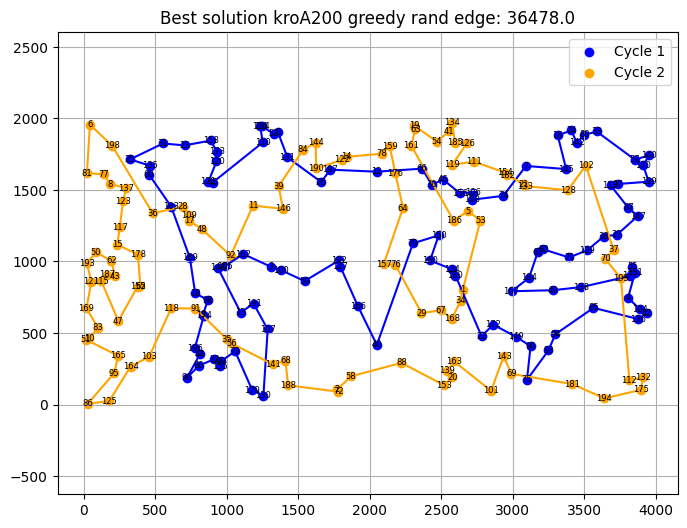

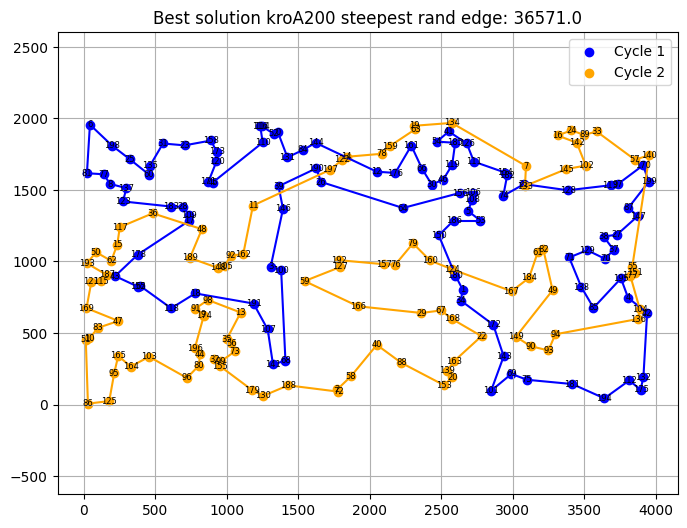

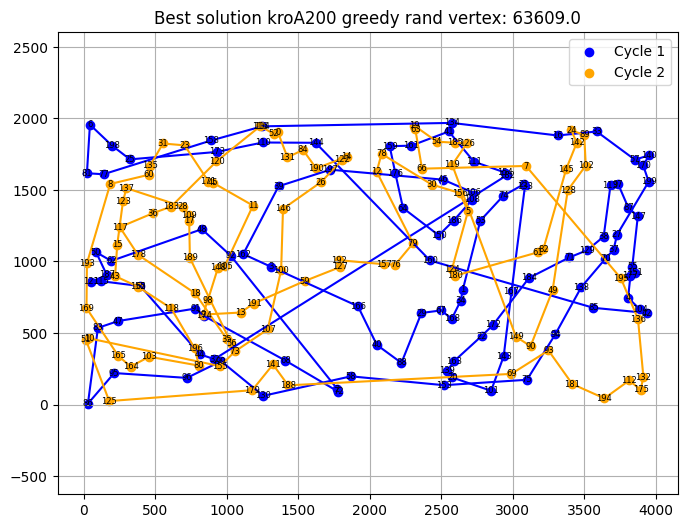

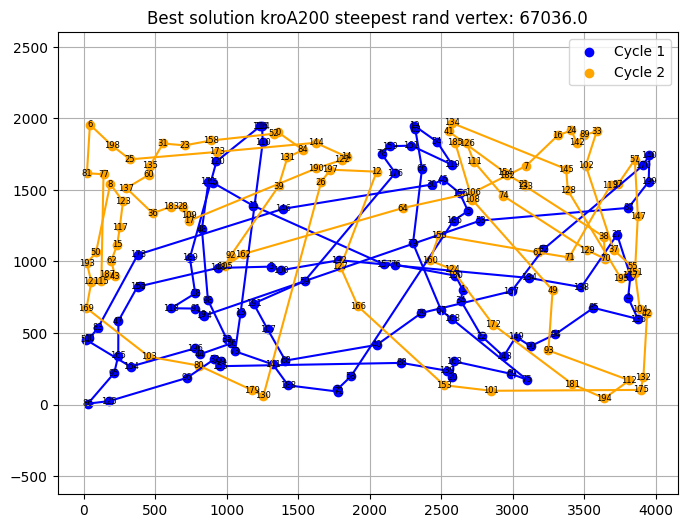

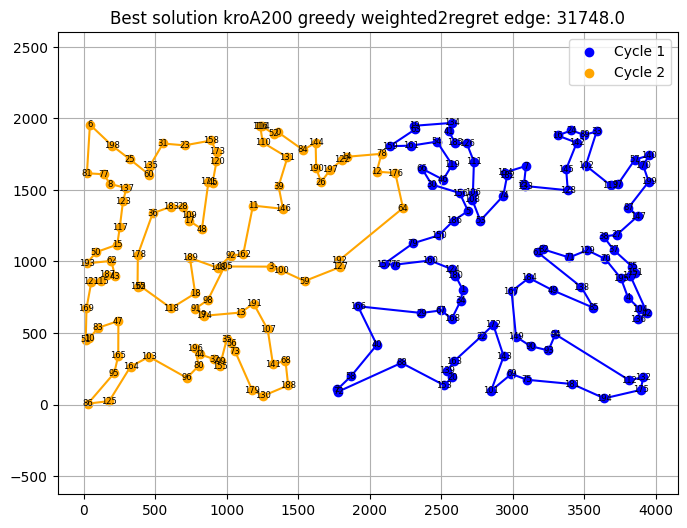

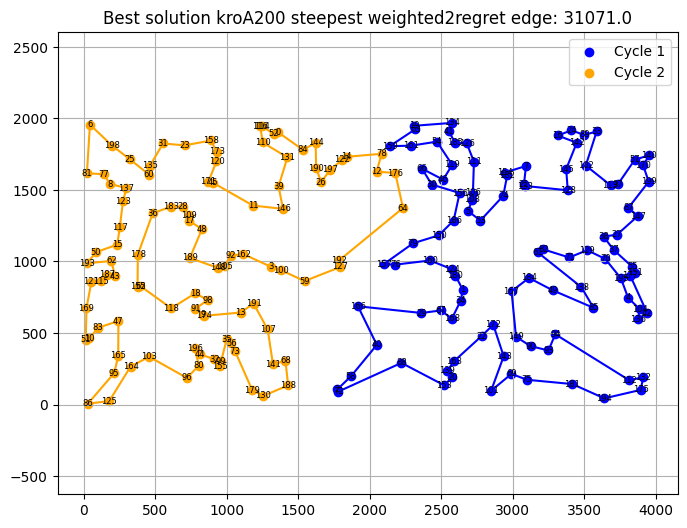

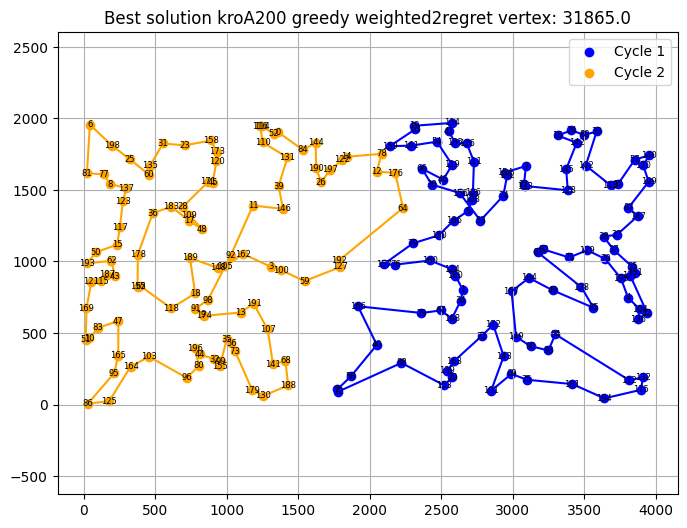

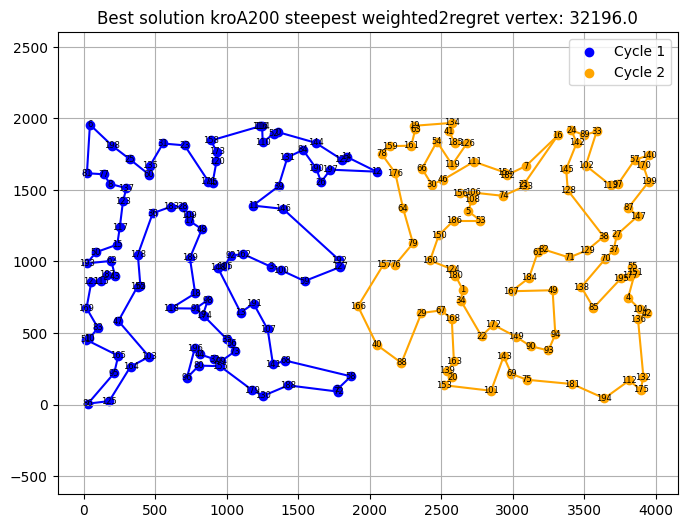

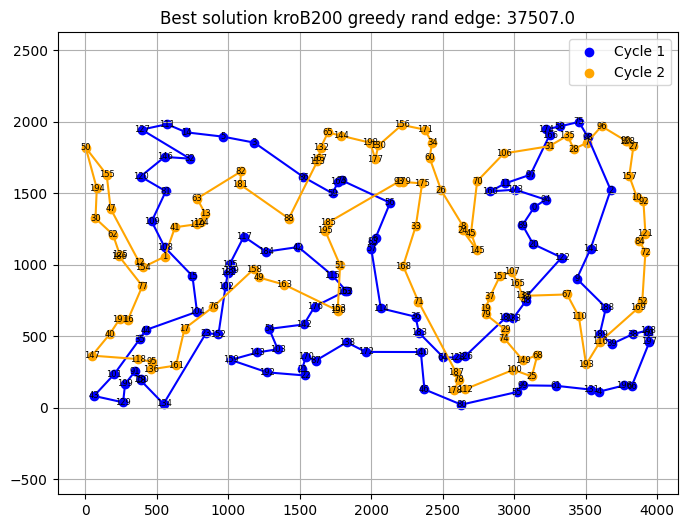

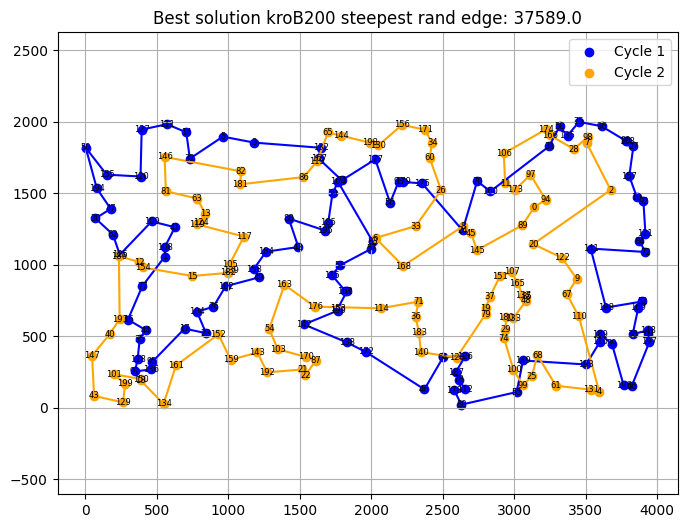

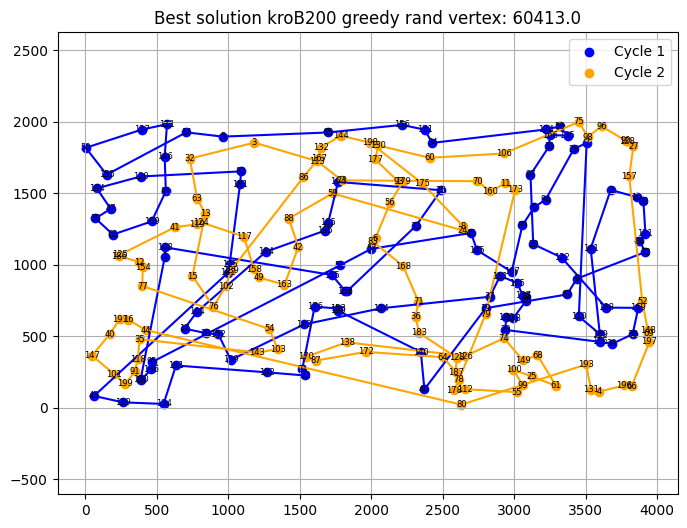

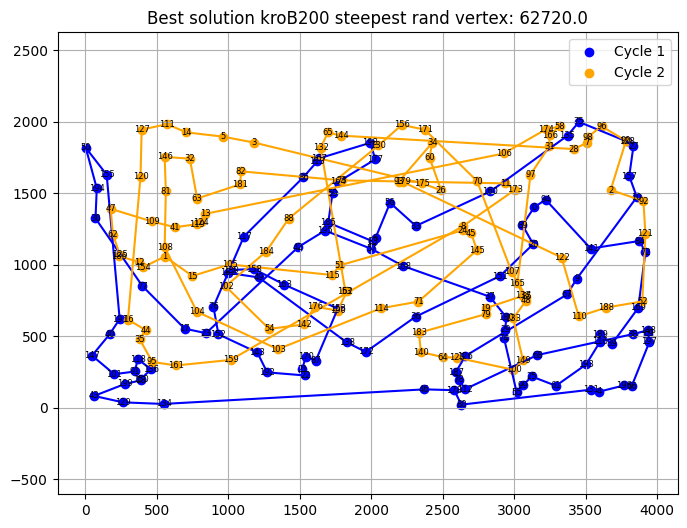

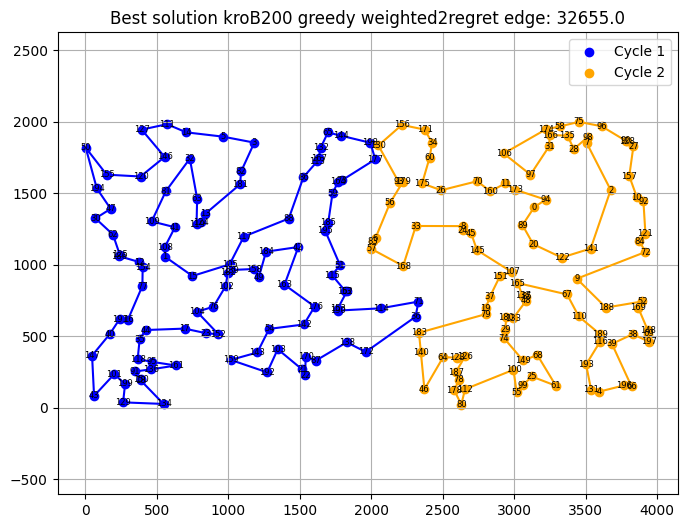

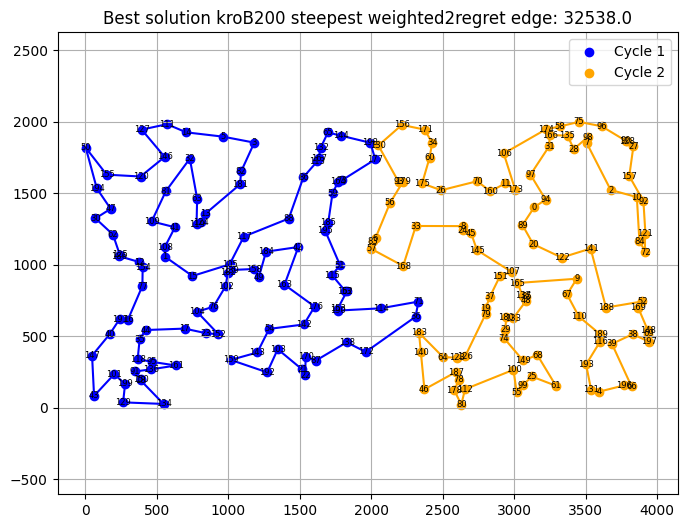

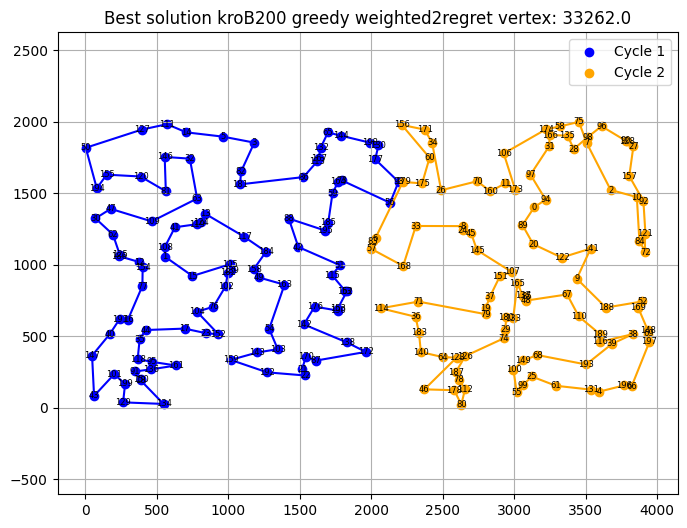

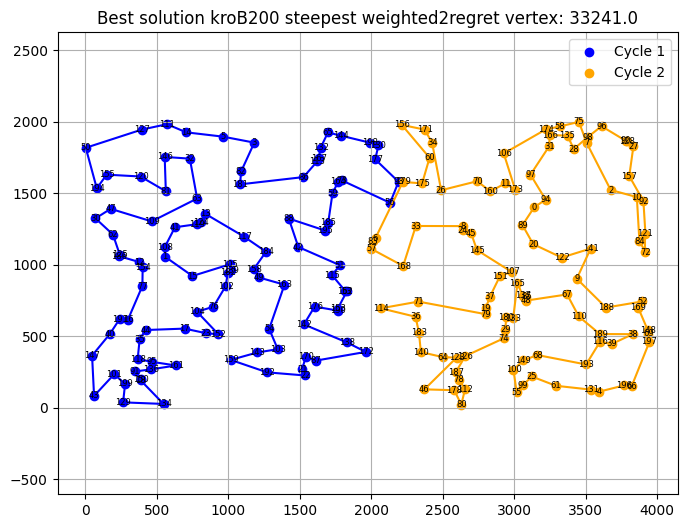

In [16]:
for i, bc in best_cycles.iterrows():
    s = Solution(bc.instance, bc.starting_solution, bc.neighborhood_type)
    s.cycle1 = eval(bc.cycle1)
    s.cycle2 = eval(bc.cycle2)
    s.plot_cycles(f"Best solution {bc.instance} {bc.algorithm} {bc.starting_solution} {bc.neighborhood_type}: {bc.score}")

In [17]:
mean_time = df[
    (df['algorithm'] == 'steepest') & (df['starting_solution'] == 'rand')
]['runtime'].mean()

mean_time

np.float64(14.21612296462059)

In [18]:
with open("random_walk_results.csv", "w") as f:
    f.write(f"instance;starting_solution;neighborhood_type;algorithm;runtime;score;cycle1;cycle2\n")

num_tests = 100
for instance in instances:
    for starting_solution in starting_solutions:
        for neighborhood_type in neighborhood_types:
            for i in range(num_tests):
                random_walk = RandomWalk(instance, starting_solution, neighborhood_type, mean_time)

                with open("random_walk_results.csv", "a") as f:
                    f.write(f"{instance};{starting_solution};{neighborhood_type};randomwalk;{mean_time};{random_walk.total_length};{random_walk.cycle1};{random_walk.cycle2}\n")


In [19]:
df2 = pd.read_csv("random_walk_results.csv", delimiter=";")

In [20]:
random_walk_stats_performance = df2.groupby(["instance", "starting_solution", "neighborhood_type"]).score.agg(["mean", "min", "max"])
random_walk_stats_performance

mean       min       max
instance starting_solution neighborhood_type                               
kroA200  rand              edge               287788.35  278098.0  294433.0
                           vertex             287068.29  280533.0  293840.0
         weighted2regret   edge                41079.71   34047.0   51227.0
                           vertex              43084.02   35211.0   51114.0
kroB200  rand              edge               282124.61  267997.0  288939.0
                           vertex             282566.38  271770.0  288238.0
         weighted2regret   edge                40367.46   34364.0   50868.0
                           vertex              43117.43   36544.0   51929.0

In [21]:
best_cycles = (
    df2.loc[
        df2.groupby(['instance', 'starting_solution', 'neighborhood_type', 'algorithm'])['score'].idxmin()
    ][['instance', 'starting_solution', 'neighborhood_type', 'algorithm', 'score', 'cycle1', 'cycle2']]
)

In [22]:
best_cycles

instance starting_solution neighborhood_type   algorithm     score  \
31   kroA200              rand              edge  randomwalk  278098.0   
175  kroA200              rand            vertex  randomwalk  280533.0   
266  kroA200   weighted2regret              edge  randomwalk   34047.0   
389  kroA200   weighted2regret            vertex  randomwalk   35211.0   
432  kroB200              rand              edge  randomwalk  267997.0   
548  kroB200              rand            vertex  randomwalk  271770.0   
654  kroB200   weighted2regret              edge  randomwalk   34364.0   
796  kroB200   weighted2regret            vertex  randomwalk   36544.0   

                                                cycle1  \
31   [133, 180, 6, 25, 50, 47, 27, 70, 60, 14, 39, ...   
175  [164, 140, 87, 75, 92, 189, 51, 141, 36, 130, ...   
266  [88, 72, 2, 58, 40, 166, 29, 67, 168, 34, 1, 1...   
389  [141, 107, 191, 13, 73, 56, 35, 174, 9, 91, 98...   
432  [187, 79, 17, 24, 31, 46, 148, 55, 60, 157, 16...   
548  [33, 177, 112, 8, 111, 146, 44, 2, 197, 79, 58...   
654  [32, 63, 109, 47, 30, 62, 125, 186, 12, 154, 7...   
796  [34, 171, 156, 130, 198, 177, 144, 65, 132, 16...   

                                                cycle2  
31   [198, 137, 166, 18, 98, 91, 122, 76, 99, 110, ...  
175  [145, 109, 59, 76, 27, 39, 128, 61, 93, 30, 54...  
266  [6, 81, 77, 8, 123, 137, 117, 28, 109, 48, 17,...  
389  [140, 57, 170, 33, 89, 24, 16, 142, 145, 128, ...  
432  [170, 111, 172, 132, 104, 20, 193, 194, 77, 34...  
548  [97, 67, 145, 23, 157, 100, 96, 107, 165, 7, 1...  
654  [66, 4, 131, 61, 25, 99, 55, 100, 149, 68, 193...  
796  [43, 129, 199, 18, 150, 134, 136, 95, 161, 159...

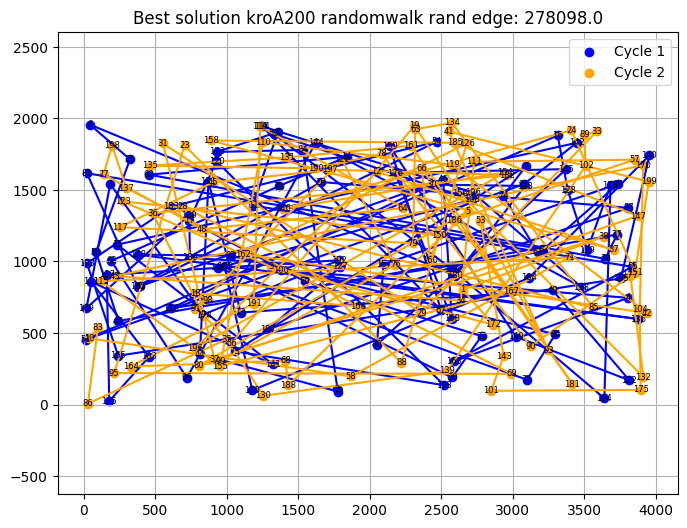

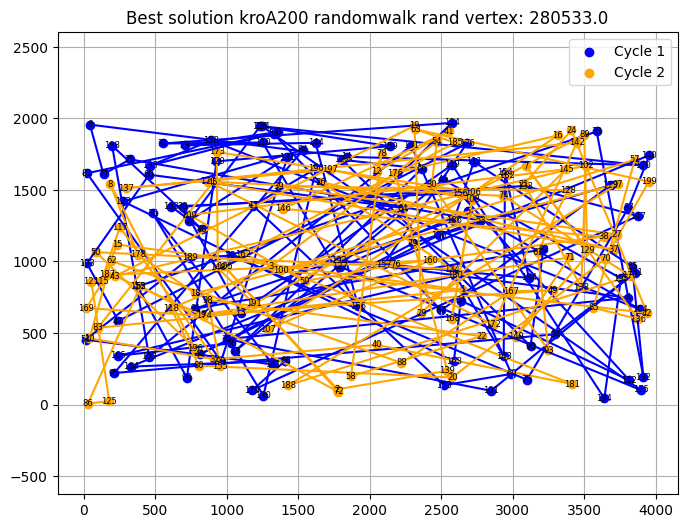

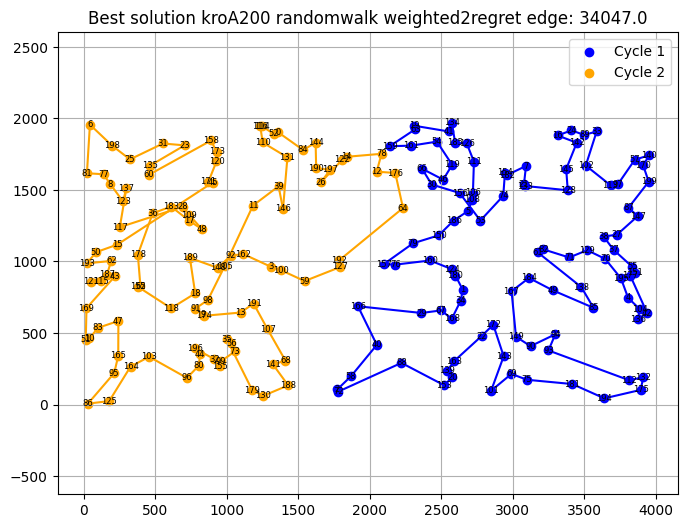

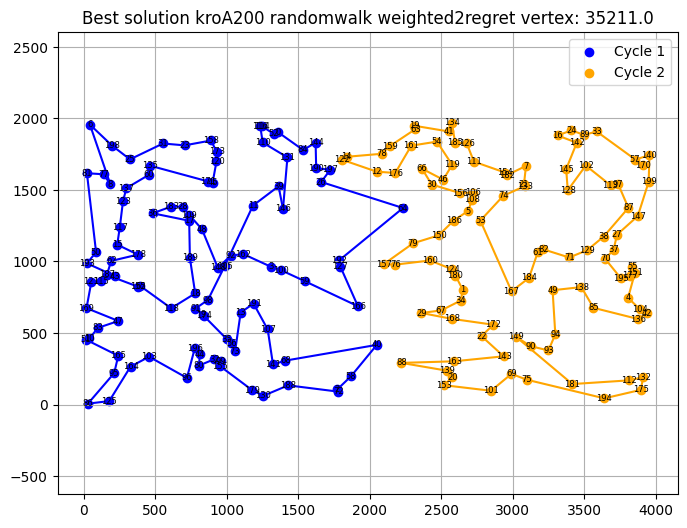

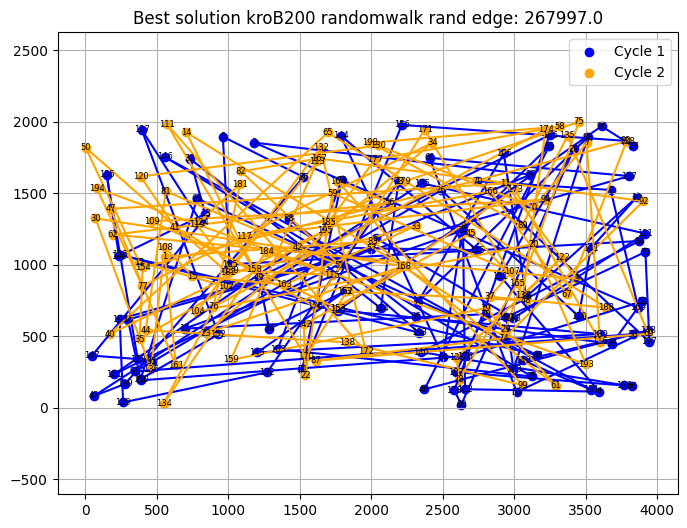

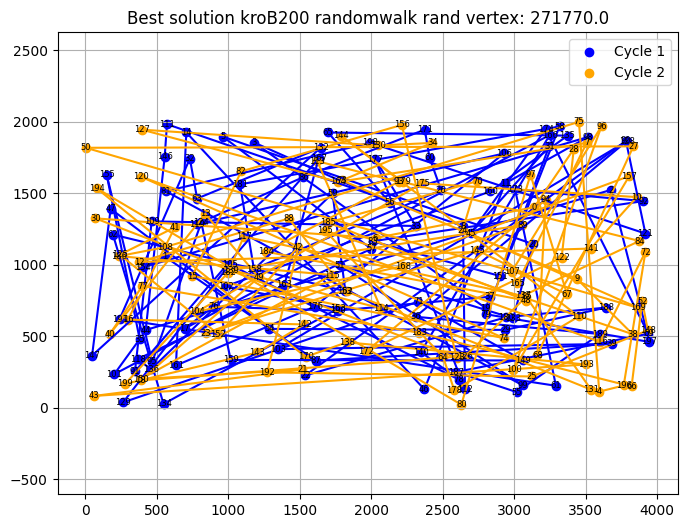

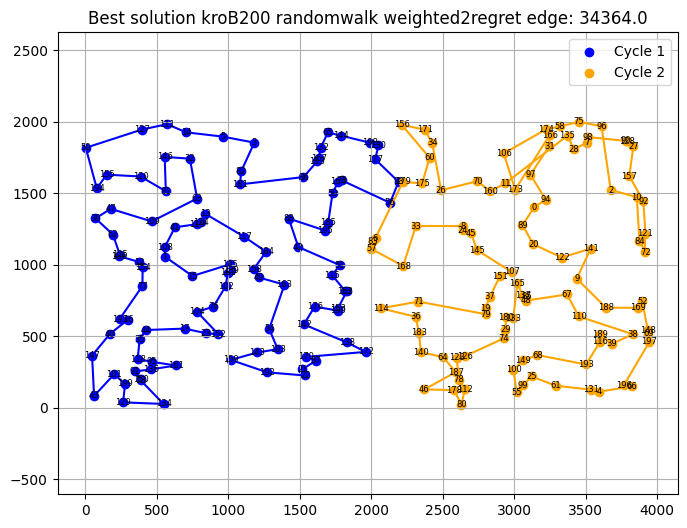

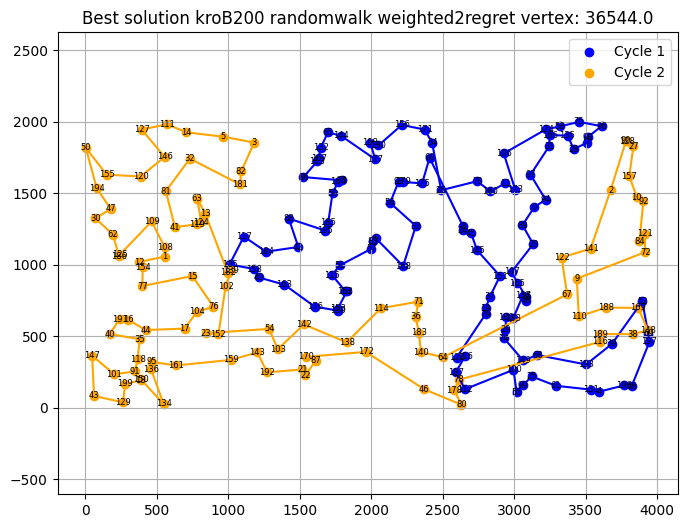

In [23]:
for i, bc in best_cycles.iterrows():
    s = Solution(bc.instance, bc.starting_solution, bc.neighborhood_type)
    s.cycle1 = eval(bc.cycle1)
    s.cycle2 = eval(bc.cycle2)
    s.plot_cycles(f"Best solution {bc.instance} {bc.algorithm} {bc.starting_solution} {bc.neighborhood_type}: {bc.score}")